<a href="https://colab.research.google.com/github/lorysduez/ProjetP5/blob/main/Projet_P5_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install transformers
!pip install sentencepiece
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import csv
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from nltk.corpus import stopwords
import transformers
import torch
from torch.utils.data import Dataset, DataLoader 
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import CamembertTokenizer, CamembertModel, CamembertForSequenceClassification
import sentencepiece as spm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

In [ ]:
from datetime import datetime

In [ ]:
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Comportement du modèle


In [ ]:
Liste_action_moins_correl = ['ORA.PA - ORANGE', 'HO.PA - THALES', 'URW.AS - UNIBAIL-RODAMCO', 'LR.PA - LEGRAND', 'ENGI.PA - ENGIE', 'VIV.PA - VIVENDI', 'WLN.PA - WORLDLINE', 'RNO.PA - RENAULT', 'SU.PA - SCHNEIDER ELECTRIC', 'SAF.PA - SAFRAN']

In [ ]:
liste_indice_mc = ['ORA.PA', 'HO.PA', 'URW.AS', 'LR.PA', 'ENGI.PA', 'VIV.PA', 'WLN.PA', 'RNO.PA', 'SU.PA','SAF.PA']

In [ ]:
action_prev = liste_indice_mc[2]

In [ ]:
df_prev = yf.download(action_prev,start,end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
test_ratio = 0.2
training_ratio = 1-test_ratio
train_size = int(training_ratio * len(df_prev))
test_size = int(test_ratio*len(df_prev))
print("train_size: "+str(train_size))
print("test_size:"+str(test_size))

train = df_prev[:train_size][['Adj Close']]
test = df_prev[train_size:][['Adj Close']]
test_2 = df_prev[train_size:]

train_size: 206
test_size:51


In [ ]:
window_size = 100
layer_units, optimizer = 50, 'adam'
cur_epochs = 15
cur_batch_size = 20
cur_LSTM_pars = {'units': layer_units,
                     'optimizer': optimizer,
                     'batch_size': cur_batch_size,
                     'epochs': cur_epochs
                     }

In [ ]:
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])

    return np.array(X), np.array(y)

In [ ]:
def MA_df(df):
  ma = [10,20,30]
  for ma in ma:
    column_name = f"MA for {ma} days"
    df[column_name] = df['Adj Close'].rolling(ma).mean()

In [ ]:
def DR_df(df):
  df['Daily Return'] = df['Adj Close'].pct_change()

In [ ]:
MA_df(df_prev)

In [ ]:
DR_df(df_prev)

In [ ]:
df_prev = df_prev.dropna(subset=['MA for 30 days'])

In [ ]:
features = ['Adj Close','Open','Volume','MA for 10 days','MA for 20 days','MA for 30 days']

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_prev[features])

In [ ]:
scaled_data_train = scaled_data[:train.shape[0]]

In [ ]:
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

In [ ]:
y_train_2 = []
for i in range(len(y_train)):
  y_train_2.append([y_train[i][0]])

In [ ]:
y_train_2 = np.array(y_train_2)

In [ ]:
def Run_LSTM(X_train, layer_units = 50):
  inp = Input(shape=(X_train.shape[1],6))

  x = LSTM(units=layer_units, return_sequences=True)(inp)
  x = LSTM(units=layer_units)(x)   
  out = Dense(1, activation='linear')(x)
  model = Model(inp, out)

  model.compile(loss = 'mean_squared_error', optimizer = 'adam')

  return model

model = Run_LSTM(X_train, layer_units=layer_units)
history = model.fit(X_train, y_train_2, epochs=cur_epochs, batch_size=cur_batch_size,
                    verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/15
5/5 [==============================] - 4s 188ms/step - loss: 0.5327 - val_loss: 0.8826
Epoch 2/15
5/5 [==============================] - 0s 21ms/step - loss: 0.2700 - val_loss: 0.6142
Epoch 3/15
5/5 [==============================] - 0s 21ms/step - loss: 0.1677 - val_loss: 0.3223
Epoch 4/15
5/5 [==============================] - 0s 18ms/step - loss: 0.1194 - val_loss: 0.2557
Epoch 5/15
5/5 [==============================] - 0s 18ms/step - loss: 0.1034 - val_loss: 0.2608
Epoch 6/15
5/5 [==============================] - 0s 20ms/step - loss: 0.0776 - val_loss: 0.2811
Epoch 7/15
5/5 [==============================] - 0s 17ms/step - loss: 0.0823 - val_loss: 0.2964
Epoch 8/15
5/5 [==============================] - 0s 20ms/step - loss: 0.0748 - val_loss: 0.2792
Epoch 9/15
5/5 [==============================] - 0s 17ms/step - loss: 0.0720 - val_loss: 0.2449
Epoch 10/15
5/5 [==============================] - 0s 16ms/step - loss: 0.0688 - val_loss: 0.2378
Epoch 11/15
5/5 [===========

In [ ]:
def preprocess_testdat(data, scaler=scaler, window_size=window_size, test=test):
    raw = data[features][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,6)
    raw = scaler.transform(raw)

    X_test = []
    for i in range(window_size, raw.shape[0]):
        X_test.append(raw[i-window_size:i])

    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))
    return X_test

In [ ]:
X_test = preprocess_testdat(df_prev)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
predicted_price = model.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [ ]:
scaler = StandardScaler()
scaler_close = scaler.fit_transform(df_prev[['Adj Close']])

In [ ]:
predicted_price = scaler.inverse_transform(predicted_price)

In [ ]:
test['Predicions_lstm'] = predicted_price

In [ ]:
def plot_stock_trend_lstm(train, test):
    fig = plt.figure(figsize = (20,10))
    plt.plot(train.index, train['Adj Close'], label = 'Train Closing Price')
    plt.plot(test.index, test['Adj Close'], label = 'Test Closing Price')
    plt.plot(test.index, test['Predicions_lstm'], label = 'Predicted Closing Price')
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")

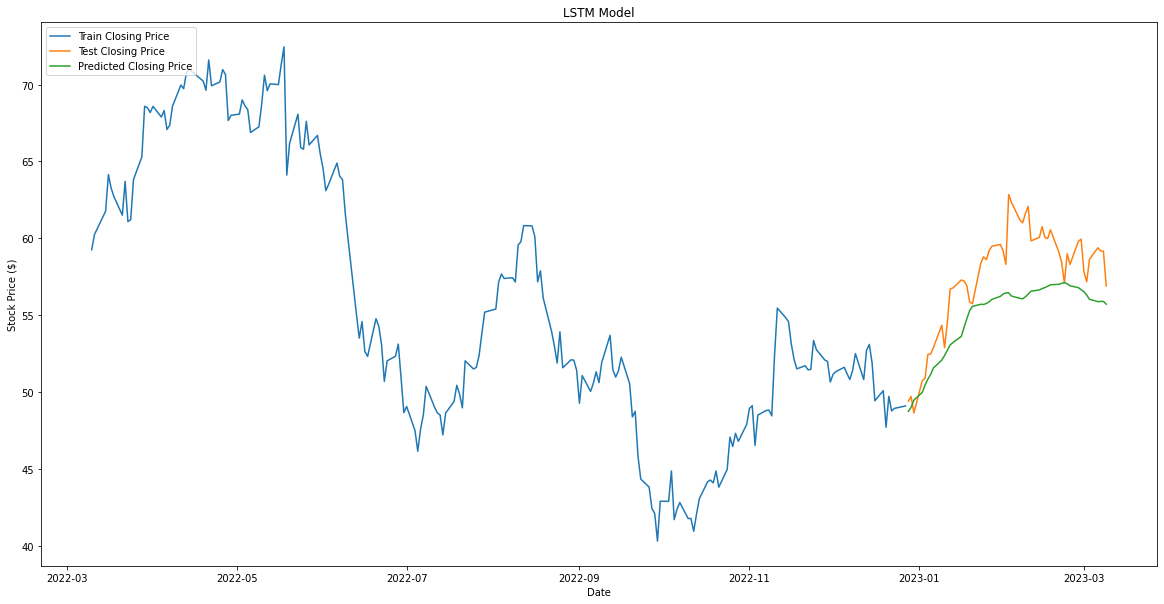

In [ ]:
plot_stock_trend_lstm(train,test)

In [ ]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return rmse

In [ ]:
def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100
    return mape

In [ ]:
rmse_lstm = calculate_rmse(np.array(test['Adj Close']),np.array(test['Predicions_lstm']))

In [ ]:
rmse_lstm

3.037186813687683

In [ ]:
mape_lstm = calculate_mape(np.array(test['Adj Close']),np.array(test['Predicions_lstm']))

In [ ]:
mape_lstm

4.435846084117039

In [ ]:
df_merged = test.join(test_2[test_2.columns.difference(test.columns)], how='outer')

In [ ]:
df_merged

,Adj Close,Predicions_lstm,Close,High,Low,Open,Volume
Date,,,,,,,
2022-12-28,49.395000,48.732708,49.395000,49.869999,48.685001,49.244999,609481
2022-12-29,49.705002,48.991730,49.705002,49.935001,48.735001,49.189999,429112
2022-12-30,48.630001,49.466011,48.630001,49.599998,48.580002,49.314999,450142
2023-01-02,50.730000,49.967110,50.730000,50.980000,49.060001,49.305000,578834
2023-01-03,50.880001,50.446239,50.880001,51.680000,50.270000,50.500000,713460
2023-01-04,52.430000,50.824684,52.430000,52.730000,51.020000,51.599998,833145
2023-01-05,52.459999,51.128796,52.459999,52.779999,51.680000,52.220001,591221
2023-01-06,52.880001,51.553417,52.880001,53.200001,51.779999,52.500000,532607
2023-01-09,54.340000,52.068272,54.340000,54.840000,52.700001,53.099998,989892


In [ ]:
MA_df(df_merged)

In [ ]:
DR_df(df_merged)

In [ ]:
df_merged

,Adj Close,Predicions_lstm,Close,High,Low,Open,Volume,MA for 10 days,MA for 20 days,MA for 30 days,Daily Return
Date,,,,,,,,,,,
2022-12-28,49.395000,48.732708,49.395000,49.869999,48.685001,49.244999,609481,NaN,NaN,NaN,NaN
2022-12-29,49.705002,48.991730,49.705002,49.935001,48.735001,49.189999,429112,NaN,NaN,NaN,0.006276
2022-12-30,48.630001,49.466011,48.630001,49.599998,48.580002,49.314999,450142,NaN,NaN,NaN,-0.021628
2023-01-02,50.730000,49.967110,50.730000,50.980000,49.060001,49.305000,578834,NaN,NaN,NaN,0.043183
2023-01-03,50.880001,50.446239,50.880001,51.680000,50.270000,50.500000,713460,NaN,NaN,NaN,0.002957
2023-01-04,52.430000,50.824684,52.430000,52.730000,51.020000,51.599998,833145,NaN,NaN,NaN,0.030464
2023-01-05,52.459999,51.128796,52.459999,52.779999,51.680000,52.220001,591221,NaN,NaN,NaN,0.000572
2023-01-06,52.880001,51.553417,52.880001,53.200001,51.779999,52.500000,532607,NaN,NaN,NaN,0.008006
2023-01-09,54.340000,52.068272,54.340000,54.840000,52.700001,53.099998,989892,NaN,NaN,NaN,0.027610


In [ ]:
df_merged['Nom'] = action_prev

In [ ]:
filename = f'/content/sample_data/comportement_modele_{action_prev}.csv'

In [ ]:
df_merged.to_csv(filename)

# Prévisions futures du modèle.

In [ ]:
def preprocess_testdat_2(raw, scaler, window_size,nbjours):
    raw_2 = raw[nbjours:]
    raw_2 = raw.reshape(-1,len(features_prev))
    raw_2 = scaler.transform(raw_2)

    X_test = []
    for i in range(60):
        X_test.append(raw_2[nbjours:][i])

    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (1, 60, 4))
    return X_test

In [ ]:
def ma_3(data,prix):
  prices = []
  for i in range(29):
    prices.append(data[len(data)-29+i][0])
  prices.append(prix)
  ma_30 = sum(prices)/30
  ma_20 = sum(prices[10:])/20
  ma_10 = sum(prices[20:])/10
  return ma_10,ma_20,ma_30

In [ ]:
def previsions(nbjours : int,data):
  previsions = []
  raw = data[features_prev][len(data)-window_size:].values
  print(raw.shape)
  for nbjours in range(nbjours): 
    X_test = preprocess_testdat_2(raw,scaler_data,window_size,nbjours)
    predicted_price_i = model.predict(X_test)
    predicted_price_i = scaler_close.inverse_transform(predicted_price_i)
    prix = predicted_price_i[0][0]
    print(prix)
    ma_10,ma_20,ma_30 = ma_3(raw,prix)
    predicted_price_i = np.append(predicted_price_i,[ma_10,ma_20,ma_30])
    print(predicted_price_i)
    raw = np.vstack((raw,predicted_price_i))
    print(raw)
    print(raw.shape)
    previsions.append(predicted_price_i.tolist())
    print(previsions)
  return raw,previsions

In [ ]:
df_final = pd.DataFrame(columns=['Adj Close','MA for 10 days','MA for 20 days','MA for 30 days','Daily Return','qualif','Compagnie'])

In [ ]:
nbjoursprevus = 10

In [ ]:
import datetime
aujourdhui = datetime.date.today()
dates = []
i =0
while len(dates)<nbjoursprevus:
  jour = aujourdhui + datetime.timedelta(days = i)
  if jour.weekday() < 5:
    dates.append(jour)
  i = i + 1
date_index = pd.DatetimeIndex(dates)

In [ ]:
def Run_LSTM(X_train, layer_units = 50):
  inp = Input(shape=(X_train.shape[1],len(features_prev)))

  x = LSTM(units=layer_units, return_sequences=True)(inp)
  x = LSTM(units=layer_units)(x)   
  out = Dense(1, activation='linear')(x)
  model = Model(inp, out)

  model.compile(loss = 'mean_squared_error', optimizer = 'adam')

  return model

In [ ]:
for actions in range(len(liste_indice_mc)):
  action_prev = liste_indice_mc[actions]
  df_prev = yf.download(action_prev, start, end)
  test_ratio = 0.2
  training_ratio = 1-test_ratio
  train_size = int(training_ratio * len(df_prev))
  test_size = int(test_ratio*len(df_prev))
  print("train_size: "+str(train_size))
  print("test_size:"+str(test_size))

  train = df_prev[:train_size][['Adj Close']]
  test = df_prev[train_size:][['Adj Close']]
  test_2 = df_prev[train_size:]
  window_size = 60
  layer_units, optimizer = 50, 'adam'
  cur_epochs = 20
  cur_batch_size = 20
  cur_LSTM_pars = {'units': layer_units,
                      'optimizer': optimizer,
                      'batch_size': cur_batch_size,
                      'epochs': cur_epochs
                      }
  MA_df(df_prev)
  DR_df(df_prev)
  df_prev = df_prev.dropna(subset=['MA for 30 days'])
  features_prev = ['Adj Close','MA for 10 days','MA for 20 days','MA for 30 days']
  scaler_data = StandardScaler()
  scaled_data = scaler_data.fit_transform(df_prev[features_prev])
  scaled_data_train = scaled_data[:train.shape[0]]
  X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)
  y_train_2 = []
  for i in range(len(y_train)):
    y_train_2.append([y_train[i][0]])
  y_train_2 = np.array(y_train_2)
  model = Run_LSTM(X_train, layer_units=layer_units)
  history = model.fit(X_train, y_train_2, epochs=cur_epochs, batch_size=cur_batch_size,
                      verbose=1, validation_split=0.1, shuffle=True)
  scaler_close = StandardScaler()
  scaled_close = scaler_close.fit_transform(df_prev[['Adj Close']])
  raw,previs = previsions(nbjoursprevus,df_prev)
  np_previsions = np.array(previs)
  df_previsions = pd.DataFrame(np_previsions,index = date_index,columns=['Adj Close','MA for 10 days','MA for 20 days','MA for 30 days'])
  df_concat = pd.concat([df_prev,df_previsions],axis = 0)
  df_concat.dropna(axis=1)
  df_concat['Daily Return'] = df_concat['Adj Close'].pct_change()
  df_concat = df_concat.dropna(axis=1, thresh = df_concat.shape[0]-1)
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")
  df_concat['Compagnie'] = Liste_action_moins_correl[actions]
  df_final = pd.concat([df_final,df_concat],axis= 0)

[*********************100%***********************]  1 of 1 completed
train_size: 206
test_size:51
Epoch 1/20
7/7 [==============================] - 4s 160ms/step - loss: 0.4016 - val_loss: 0.1890
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 0.2203 - val_loss: 0.0425
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.1477 - val_loss: 0.0086
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 0.1293 - val_loss: 0.0376
Epoch 5/20
7/7 [==============================] - 0s 17ms/step - loss: 0.1225 - val_loss: 0.0595
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.0961 - val_loss: 0.0143
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.0902 - val_loss: 0.0229
Epoch 8/20
7/7 [==============================] - 0s 17ms/step - loss: 0.0727 - val_loss: 0.0357
Epoch 9/20
7/7 [==============================] - 0s 18ms/step - loss: 0.0570 - val_loss: 0.0349
Epoch 10/20
7/7 [===========

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 630ms/step
10.332383
[10.33238316 10.75543833 10.63171921 10.29697946]
[[ 9.27299976  9.30909996  9.42970223  9.43450486]
 [ 9.18000031  9.29169998  9.4136384   9.42528133]
 [ 9.22500038  9.27690001  9.39570665  9.41791309]
 [ 9.13500023  9.24300003  9.37361403  9.4065436 ]
 [ 9.24199963  9.23380003  9.35750113  9.39967737]
 [ 9.30300045  9.2420001   9.34167686  9.39471534]
 [ 9.35900021  9.24800014  9.32855568  9.39410686]
 [ 9.36600018  9.25880013  9.31806145  9.39140631]
 [ 9.33100033  9.26850014  9.30770669  9.38724842]
 [ 9.39400005  9.28080015  9.30418382  9.38525511]
 [ 9.28100014  9.28160019  9.29535007  9.38033489]
 [ 9.39400005  9.30300016  9.29735007  9.37675899]
 [ 9.52799988  9.33330011  9.30510006  9.37490447]
 [ 9.81400013  9.4012001   9.32210007  9.38280938]
 [ 9.89700031  9.46670017  9.3502501   9.39390081]
 [ 9.89099979  9.52550011  9.3837501   9.40295127]
 [ 9.88599968  9.57820005  9.4131001   9.41177047]
 [ 9.8920002   9.630

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


10.237639
[10.23763943 10.59857931 10.69328966 10.35612644]
[[ 9.27299976  9.30909996  9.42970223  9.43450486]
 [ 9.18000031  9.29169998  9.4136384   9.42528133]
 [ 9.22500038  9.27690001  9.39570665  9.41791309]
 [ 9.13500023  9.24300003  9.37361403  9.4065436 ]
 [ 9.24199963  9.23380003  9.35750113  9.39967737]
 [ 9.30300045  9.2420001   9.34167686  9.39471534]
 [ 9.35900021  9.24800014  9.32855568  9.39410686]
 [ 9.36600018  9.25880013  9.31806145  9.39140631]
 [ 9.33100033  9.26850014  9.30770669  9.38724842]
 [ 9.39400005  9.28080015  9.30418382  9.38525511]
 [ 9.28100014  9.28160019  9.29535007  9.38033489]
 [ 9.39400005  9.30300016  9.29735007  9.37675899]
 [ 9.52799988  9.33330011  9.30510006  9.37490447]
 [ 9.81400013  9.4012001   9.32210007  9.38280938]
 [ 9.89700031  9.46670017  9.3502501   9.39390081]
 [ 9.89099979  9.52550011  9.3837501   9.40295127]
 [ 9.88599968  9.57820005  9.4131001   9.41177047]
 [ 9.8920002   9.63080006  9.44480009  9.42230765]
 [ 9.7869997   9.67639

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
10.188258
[10.18825817 10.54240513 10.67190256 10.37413505]
[[ 9.27299976  9.30909996  9.42970223  9.43450486]
 [ 9.18000031  9.29169998  9.4136384   9.42528133]
 [ 9.22500038  9.27690001  9.39570665  9.41791309]
 [ 9.13500023  9.24300003  9.37361403  9.4065436 ]
 [ 9.24199963  9.23380003  9.35750113  9.39967737]
 [ 9.30300045  9.2420001   9.34167686  9.39471534]
 [ 9.35900021  9.24800014  9.32855568  9.39410686]
 [ 9.36600018  9.25880013  9.31806145  9.39140631]
 [ 9.33100033  9.26850014  9.30770669  9.38724842]
 [ 9.39400005  9.28080015  9.30418382  9.38525511]
 [ 9.28100014  9.28160019  9.29535007  9.38033489]
 [ 9.39400005  9.30300016  9.29735007  9.37675899]
 [ 9.52799988  9.33330011  9.30510006  9.37490447]
 [ 9.81400013  9.4012001   9.32210007  9.38280938]
 [ 9.89700031  9.46670017  9.3502501   9.39390081]
 [ 9.89099979  9.52550011  9.3837501   9.40295127]
 [ 9.88599968  9.57820005  9.4131001   9.41177047]
 [ 9.8920002   9.6308

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
10.011344
[10.01134396 10.32344112 10.56642056 10.42448041]
[[ 9.27299976  9.30909996  9.42970223  9.43450486]
 [ 9.18000031  9.29169998  9.4136384   9.42528133]
 [ 9.22500038  9.27690001  9.39570665  9.41791309]
 [ 9.13500023  9.24300003  9.37361403  9.4065436 ]
 [ 9.24199963  9.23380003  9.35750113  9.39967737]
 [ 9.30300045  9.2420001   9.34167686  9.39471534]
 [ 9.35900021  9.24800014  9.32855568  9.39410686]
 [ 9.36600018  9.25880013  9.31806145  9.39140631]
 [ 9.33100033  9.26850014  9.30770669  9.38724842]
 [ 9.39400005  9.28080015  9.30418382  9.38525511]
 [ 9.28100014  9.28160019  9.29535007  9.38033489]
 [ 9.39400005  9.30300016  9.29735007  9.37675899]
 [ 9.52799988  9.33330011  9.30510006  9.37490447]
 [ 9.81400013  9.4012001   9.32210007  9.38280938]
 [ 9.89700031  9.46670017  9.3502501   9.39390081]
 [ 9.89099979  9.52550011  9.3837501   9.40295127]
 [ 9.88599968  9.57820005  9.4131001   9.41177047]
 [ 9.8920002   9.6308

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
9.94716
[ 9.94715977 10.23555708 10.51967854 10.43551906]
[[ 9.27299976  9.30909996  9.42970223  9.43450486]
 [ 9.18000031  9.29169998  9.4136384   9.42528133]
 [ 9.22500038  9.27690001  9.39570665  9.41791309]
 [ 9.13500023  9.24300003  9.37361403  9.4065436 ]
 [ 9.24199963  9.23380003  9.35750113  9.39967737]
 [ 9.30300045  9.2420001   9.34167686  9.39471534]
 [ 9.35900021  9.24800014  9.32855568  9.39410686]
 [ 9.36600018  9.25880013  9.31806145  9.39140631]
 [ 9.33100033  9.26850014  9.30770669  9.38724842]
 [ 9.39400005  9.28080015  9.30418382  9.38525511]
 [ 9.28100014  9.28160019  9.29535007  9.38033489]
 [ 9.39400005  9.30300016  9.29735007  9.37675899]
 [ 9.52799988  9.33330011  9.30510006  9.37490447]
 [ 9.81400013  9.4012001   9.32210007  9.38280938]
 [ 9.89700031  9.46670017  9.3502501   9.39390081]
 [ 9.89099979  9.52550011  9.3837501   9.40295127]
 [ 9.88599968  9.57820005  9.4131001   9.41177047]
 [ 9.8920002   9.630800

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")


[*********************100%***********************]  1 of 1 completed
train_size: 206
test_size:51
Epoch 1/20
7/7 [==============================] - 5s 126ms/step - loss: 0.5605 - val_loss: 0.3650
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3357 - val_loss: 0.8406
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2821 - val_loss: 0.7033
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2506 - val_loss: 0.5851
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2279 - val_loss: 0.9615
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2000 - val_loss: 0.7752
Epoch 7/20
7/7 [==============================] - 0s 13ms/step - loss: 0.1772 - val_loss: 1.0047
Epoch 8/20
7/7 [==============================] - 0s 13ms/step - loss: 0.1722 - val_loss: 0.8929
Epoch 9/20
7/7 [==============================] - 0s 12ms/step - loss: 0.1468 - val_loss: 1.0190
Epoch 10/20
7/7 [===========

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 737ms/step
121.814575
[121.8145752  131.11145706 130.43822899 126.95048574]
[[119.69999695 120.84528732 120.66116142 120.22195892]
 [119.5        120.67500076 120.81961708 120.05085475]
 [119.59999847 120.46500015 120.89110184 119.91125488]
 [119.5        120.08499985 120.86561584 119.76666463]
 [121.30000305 120.16500015 120.87793007 119.66053187]
 [120.5        119.94000015 120.82538719 119.60561778]
 [118.59999847 119.8        120.65050125 119.83868281]
 [119.15000153 119.56500015 120.5230011  120.07350998]
 [118.40000153 119.59000015 120.38534393 120.1689949 ]
 [119.40000153 119.56500015 120.28277245 120.19672775]
 [119.30000305 119.52500076 120.18514404 120.2824412 ]
 [120.         119.57500076 120.12500076 120.40474497]
 [116.05000305 119.22000122 119.84250069 120.3340683 ]
 [113.94999695 118.66500092 119.37500038 120.13207753]
 [113.5        117.88500061 119.02500038 119.88028692]
 [115.94999695 117.43000031 118.68500023 119.69359156]
 [

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step
121.07802
[121.07801819 127.55647507 129.59573784 126.85882492]
[[119.69999695 120.84528732 120.66116142 120.22195892]
 [119.5        120.67500076 120.81961708 120.05085475]
 [119.59999847 120.46500015 120.89110184 119.91125488]
 [119.5        120.08499985 120.86561584 119.76666463]
 [121.30000305 120.16500015 120.87793007 119.66053187]
 [120.5        119.94000015 120.82538719 119.60561778]
 [118.59999847 119.8        120.65050125 119.83868281]
 [119.15000153 119.56500015 120.5230011  120.07350998]
 [118.40000153 119.59000015 120.38534393 120.1689949 ]
 [119.40000153 119.56500015 120.28277245 120.19672775]
 [119.30000305 119.52500076 120.18514404 120.2824412 ]
 [120.         119.57500076 120.12500076 120.40474497]
 [116.05000305 119.22000122 119.84250069 120.3340683 ]
 [113.94999695 118.66500092 119.37500038 120.13207753]
 [113.5        117.88500061 119.02500038 119.88028692]
 [115.94999695 117.43000031 118.68500023 119.69359156]
 [11

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step
119.76699
[119.76699066 123.86678467 128.25339279 127.01226196]
[[119.69999695 120.84528732 120.66116142 120.22195892]
 [119.5        120.67500076 120.81961708 120.05085475]
 [119.59999847 120.46500015 120.89110184 119.91125488]
 [119.5        120.08499985 120.86561584 119.76666463]
 [121.30000305 120.16500015 120.87793007 119.66053187]
 [120.5        119.94000015 120.82538719 119.60561778]
 [118.59999847 119.8        120.65050125 119.83868281]
 [119.15000153 119.56500015 120.5230011  120.07350998]
 [118.40000153 119.59000015 120.38534393 120.1689949 ]
 [119.40000153 119.56500015 120.28277245 120.19672775]
 [119.30000305 119.52500076 120.18514404 120.2824412 ]
 [120.         119.57500076 120.12500076 120.40474497]
 [116.05000305 119.22000122 119.84250069 120.3340683 ]
 [113.94999695 118.66500092 119.37500038 120.13207753]
 [113.5        117.88500061 119.02500038 119.88028692]
 [115.94999695 117.43000031 118.68500023 119.69359156]
 [11

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step
117.79909
[117.79908752 120.21726913 126.25113449 127.0374232 ]
[[119.69999695 120.84528732 120.66116142 120.22195892]
 [119.5        120.67500076 120.81961708 120.05085475]
 [119.59999847 120.46500015 120.89110184 119.91125488]
 [119.5        120.08499985 120.86561584 119.76666463]
 [121.30000305 120.16500015 120.87793007 119.66053187]
 [120.5        119.94000015 120.82538719 119.60561778]
 [118.59999847 119.8        120.65050125 119.83868281]
 [119.15000153 119.56500015 120.5230011  120.07350998]
 [118.40000153 119.59000015 120.38534393 120.1689949 ]
 [119.40000153 119.56500015 120.28277245 120.19672775]
 [119.30000305 119.52500076 120.18514404 120.2824412 ]
 [120.         119.57500076 120.12500076 120.40474497]
 [116.05000305 119.22000122 119.84250069 120.3340683 ]
 [113.94999695 118.66500092 119.37500038 120.13207753]
 [113.5        117.88500061 119.02500038 119.88028692]
 [115.94999695 117.43000031 118.68500023 119.69359156]
 [11

<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")


Epoch 1/20
7/7 [==============================] - 5s 219ms/step - loss: 0.4054 - val_loss: 0.7518
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2577 - val_loss: 0.3687
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2073 - val_loss: 0.3147
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.1557 - val_loss: 0.2759
Epoch 5/20
7/7 [==============================] - 0s 13ms/step - loss: 0.1212 - val_loss: 0.3048
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.1113 - val_loss: 0.2815
Epoch 7/20
7/7 [==============================] - 0s 12ms/step - loss: 0.0944 - val_loss: 0.2478
Epoch 8/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0857 - val_loss: 0.2577
Epoch 9/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0796 - val_loss: 0.3025
Epoch 10/20
7/7 [==============================] - 0s 12ms/step - loss: 0.0737 - val_loss: 0.3320
Epoch 11/20
7/7 [===========

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 618ms/step
53.844757
[53.84475708 58.17847519 58.75423737 59.4341582 ]
[[51.88000107 51.72600021 51.76499996 51.74366684]
 [49.41999817 51.53600006 51.66099987 51.77466672]
 [50.08000183 51.3840004  51.57999992 51.81766675]
 [47.70000076 51.03500061 51.39300003 51.78066673]
 [49.70999908 50.92500038 51.30550003 51.82300008]
 [48.75999832 50.66300011 51.07600002 51.70233332]
 [48.92499924 50.30649986 50.88474998 51.48483327]
 [49.08499908 50.13499985 50.73499985 51.29333318]
 [49.39500046 49.80449982 50.60574989 51.12083321]
 [49.70500183 49.46599998 50.55900002 51.00666656]
 [48.63000107 49.14099998 50.4335001  50.8903333 ]
 [50.72999954 49.27200012 50.40400009 50.86466662]
 [50.88000107 49.35200005 50.36800022 50.8373333 ]
 [52.43000031 49.825      50.43000031 50.87033335]
 [52.45999908 50.1        50.51250019 50.90366669]
 [52.88000107 50.51200027 50.58750019 50.88800011]
 [54.34000015 51.05350037 50.68000011 50.94100011]
 [52.88000107 51.433

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
52.45618
[52.45618057 55.94264526 57.32982216 58.51588147]
[[51.88000107 51.72600021 51.76499996 51.74366684]
 [49.41999817 51.53600006 51.66099987 51.77466672]
 [50.08000183 51.3840004  51.57999992 51.81766675]
 [47.70000076 51.03500061 51.39300003 51.78066673]
 [49.70999908 50.92500038 51.30550003 51.82300008]
 [48.75999832 50.66300011 51.07600002 51.70233332]
 [48.92499924 50.30649986 50.88474998 51.48483327]
 [49.08499908 50.13499985 50.73499985 51.29333318]
 [49.39500046 49.80449982 50.60574989 51.12083321]
 [49.70500183 49.46599998 50.55900002 51.00666656]
 [48.63000107 49.14099998 50.4335001  50.8903333 ]
 [50.72999954 49.27200012 50.40400009 50.86466662]
 [50.88000107 49.35200005 50.36800022 50.8373333 ]
 [52.43000031 49.825      50.43000031 50.87033335]
 [52.45999908 50.1        50.51250019 50.90366669]
 [52.88000107 50.51200027 50.58750019 50.88800011]
 [54.34000015 51.05350037 50.68000011 50.94100011]
 [52.88000107 51.43300

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
50.24312
[50.24311829 52.75850601 55.79625282 57.12783508]
[[51.88000107 51.72600021 51.76499996 51.74366684]
 [49.41999817 51.53600006 51.66099987 51.77466672]
 [50.08000183 51.3840004  51.57999992 51.81766675]
 [47.70000076 51.03500061 51.39300003 51.78066673]
 [49.70999908 50.92500038 51.30550003 51.82300008]
 [48.75999832 50.66300011 51.07600002 51.70233332]
 [48.92499924 50.30649986 50.88474998 51.48483327]
 [49.08499908 50.13499985 50.73499985 51.29333318]
 [49.39500046 49.80449982 50.60574989 51.12083321]
 [49.70500183 49.46599998 50.55900002 51.00666656]
 [48.63000107 49.14099998 50.4335001  50.8903333 ]
 [50.72999954 49.27200012 50.40400009 50.86466662]
 [50.88000107 49.35200005 50.36800022 50.8373333 ]
 [52.43000031 49.825      50.43000031 50.87033335]
 [52.45999908 50.1        50.51250019 50.90366669]
 [52.88000107 50.51200027 50.58750019 50.88800011]
 [54.34000015 51.05350037 50.68000011 50.94100011]
 [52.88000107 51.43300

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")


[*********************100%***********************]  1 of 1 completed
train_size: 206
test_size:51
Epoch 1/20
7/7 [==============================] - 5s 142ms/step - loss: 0.5232 - val_loss: 0.6974
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3037 - val_loss: 0.6571
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2523 - val_loss: 0.5811
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2120 - val_loss: 0.5164
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2010 - val_loss: 0.4413
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.1767 - val_loss: 0.3933
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.1749 - val_loss: 0.3518
Epoch 8/20
7/7 [==============================] - 0s 13ms/step - loss: 0.1744 - val_loss: 0.3369
Epoch 9/20
7/7 [==============================] - 0s 14ms/step - loss: 0.1631 - val_loss: 0.3216
Epoch 10/20
7/7 [===========

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 1s/step
77.95702
[77.95702362 87.43970261 87.80885124 86.35390091]
[[77.37999725 78.99399872 79.08499985 78.52799962]
 [76.66000366 78.69999924 78.94599991 78.61399968]
 [76.63999939 78.42399902 78.83400002 78.70866623]
 [75.72000122 78.10999908 78.66199989 78.71999969]
 [76.66000366 77.85599976 78.49599991 78.75199992]
 [75.04000092 77.56800003 78.25       78.62333323]
 [75.58000183 77.21399994 78.02099991 78.47400004]
 [75.86000061 76.96600037 77.86399994 78.3446668 ]
 [75.30000305 76.48600082 77.72600021 78.19066696]
 [76.27999878 76.11200104 77.66599998 78.12133357]
 [74.81999969 75.85600128 77.425      78.00866699]
 [75.22000122 75.71200104 77.20600014 77.86800028]
 [75.90000153 75.63800125 77.03100014 77.76866709]
 [77.76000214 75.84200134 76.97600021 77.72200038]
 [78.40000153 76.01600113 76.93600044 77.66933365]
 [79.48000336 76.46000137 77.0140007  77.65333379]
 [80.81999969 76.98400116 77.09900055 77.67533366]
 [79.36000061 77.3340011

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
76.634964
[76.63496399 83.21967163 85.59383545 85.63255717]
[[77.37999725 78.99399872 79.08499985 78.52799962]
 [76.66000366 78.69999924 78.94599991 78.61399968]
 [76.63999939 78.42399902 78.83400002 78.70866623]
 [75.72000122 78.10999908 78.66199989 78.71999969]
 [76.66000366 77.85599976 78.49599991 78.75199992]
 [75.04000092 77.56800003 78.25       78.62333323]
 [75.58000183 77.21399994 78.02099991 78.47400004]
 [75.86000061 76.96600037 77.86399994 78.3446668 ]
 [75.30000305 76.48600082 77.72600021 78.19066696]
 [76.27999878 76.11200104 77.66599998 78.12133357]
 [74.81999969 75.85600128 77.425      78.00866699]
 [75.22000122 75.71200104 77.20600014 77.86800028]
 [75.90000153 75.63800125 77.03100014 77.76866709]
 [77.76000214 75.84200134 76.97600021 77.72200038]
 [78.40000153 76.01600113 76.93600044 77.66933365]
 [79.48000336 76.46000137 77.0140007  77.65333379]
 [80.81999969 76.98400116 77.09900055 77.67533366]
 [79.36000061 77.3340

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 36ms/step
76.04028
[76.0402832  79.3644165  83.73320847 84.87213923]
[[77.37999725 78.99399872 79.08499985 78.52799962]
 [76.66000366 78.69999924 78.94599991 78.61399968]
 [76.63999939 78.42399902 78.83400002 78.70866623]
 [75.72000122 78.10999908 78.66199989 78.71999969]
 [76.66000366 77.85599976 78.49599991 78.75199992]
 [75.04000092 77.56800003 78.25       78.62333323]
 [75.58000183 77.21399994 78.02099991 78.47400004]
 [75.86000061 76.96600037 77.86399994 78.3446668 ]
 [75.30000305 76.48600082 77.72600021 78.19066696]
 [76.27999878 76.11200104 77.66599998 78.12133357]
 [74.81999969 75.85600128 77.425      78.00866699]
 [75.22000122 75.71200104 77.20600014 77.86800028]
 [75.90000153 75.63800125 77.03100014 77.76866709]
 [77.76000214 75.84200134 76.97600021 77.72200038]
 [78.40000153 76.01600113 76.93600044 77.66933365]
 [79.48000336 76.46000137 77.0140007  77.65333379]
 [80.81999969 76.98400116 77.09900055 77.67533366]
 [79.36000061 77.33400

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")


[*********************100%***********************]  1 of 1 completed
train_size: 206
test_size:51
Epoch 1/20
7/7 [==============================] - 4s 125ms/step - loss: 0.4903 - val_loss: 0.6089
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 0.3022 - val_loss: 0.2069
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 0.2076 - val_loss: 0.1165
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.1658 - val_loss: 0.1242
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.1432 - val_loss: 0.1208
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.1293 - val_loss: 0.1125
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.1148 - val_loss: 0.1139
Epoch 8/20
7/7 [==============================] - 0s 14ms/step - loss: 0.1019 - val_loss: 0.1128
Epoch 9/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0945 - val_loss: 0.1139
Epoch 10/20
7/7 [===========

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 935ms/step
13.955333
[13.95533276 13.92893333 13.79566669 13.54384448]
[[13.98799992 14.36339998 14.40090003 14.23013331]
 [13.8920002  14.30719995 14.37650003 14.24193331]
 [13.95400047 14.25880003 14.34870005 14.25759999]
 [13.49400043 14.15860004 14.29900007 14.26040001]
 [13.7159996  14.08120003 14.26530004 14.27186667]
 [13.61400032 14.01340008 14.22350006 14.26233336]
 [13.58199978 13.93320007 14.18120003 14.24873336]
 [13.61800003 13.85560007 14.14350004 14.22793338]
 [13.41399956 13.7618     14.09620004 14.19640004]
 [13.53199959 13.68039999 14.04679999 14.17200003]
 [13.38799953 13.62039995 13.99189997 14.14073334]
 [13.55599976 13.58679991 13.94699993 14.11326666]
 [13.50800037 13.5421999  13.90049996 14.07986666]
 [13.24600029 13.51739988 13.83799996 14.03846668]
 [13.35000038 13.48079996 13.78099999 14.00380001]
 [12.9460001  13.41399994 13.71370001 13.95366669]
 [13.16399956 13.37219992 13.6527     13.91153332]
 [13.15600014 13.325

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step
13.930542
[13.93054199 13.97206764 13.90443387 13.63348923]
[[13.98799992 14.36339998 14.40090003 14.23013331]
 [13.8920002  14.30719995 14.37650003 14.24193331]
 [13.95400047 14.25880003 14.34870005 14.25759999]
 [13.49400043 14.15860004 14.29900007 14.26040001]
 [13.7159996  14.08120003 14.26530004 14.27186667]
 [13.61400032 14.01340008 14.22350006 14.26233336]
 [13.58199978 13.93320007 14.18120003 14.24873336]
 [13.61800003 13.85560007 14.14350004 14.22793338]
 [13.41399956 13.7618     14.09620004 14.19640004]
 [13.53199959 13.68039999 14.04679999 14.17200003]
 [13.38799953 13.62039995 13.99189997 14.14073334]
 [13.55599976 13.58679991 13.94699993 14.11326666]
 [13.50800037 13.5421999  13.90049996 14.07986666]
 [13.24600029 13.51739988 13.83799996 14.03846668]
 [13.35000038 13.48079996 13.78099999 14.00380001]
 [12.9460001  13.41399994 13.71370001 13.95366669]
 [13.16399956 13.37219992 13.6527     13.91153332]
 [13.15600014 13.3259

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step
13.852265
[13.85226536 13.97318316 13.96319165 13.72032776]
[[13.98799992 14.36339998 14.40090003 14.23013331]
 [13.8920002  14.30719995 14.37650003 14.24193331]
 [13.95400047 14.25880003 14.34870005 14.25759999]
 [13.49400043 14.15860004 14.29900007 14.26040001]
 [13.7159996  14.08120003 14.26530004 14.27186667]
 [13.61400032 14.01340008 14.22350006 14.26233336]
 [13.58199978 13.93320007 14.18120003 14.24873336]
 [13.61800003 13.85560007 14.14350004 14.22793338]
 [13.41399956 13.7618     14.09620004 14.19640004]
 [13.53199959 13.68039999 14.04679999 14.17200003]
 [13.38799953 13.62039995 13.99189997 14.14073334]
 [13.55599976 13.58679991 13.94699993 14.11326666]
 [13.50800037 13.5421999  13.90049996 14.07986666]
 [13.24600029 13.51739988 13.83799996 14.03846668]
 [13.35000038 13.48079996 13.78099999 14.00380001]
 [12.9460001  13.41399994 13.71370001 13.95366669]
 [13.16399956 13.37219992 13.6527     13.91153332]
 [13.15600014 13.3259

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 30ms/step
13.74712
[13.7471199  13.87826262 13.90683136 13.79822092]
[[13.98799992 14.36339998 14.40090003 14.23013331]
 [13.8920002  14.30719995 14.37650003 14.24193331]
 [13.95400047 14.25880003 14.34870005 14.25759999]
 [13.49400043 14.15860004 14.29900007 14.26040001]
 [13.7159996  14.08120003 14.26530004 14.27186667]
 [13.61400032 14.01340008 14.22350006 14.26233336]
 [13.58199978 13.93320007 14.18120003 14.24873336]
 [13.61800003 13.85560007 14.14350004 14.22793338]
 [13.41399956 13.7618     14.09620004 14.19640004]
 [13.53199959 13.68039999 14.04679999 14.17200003]
 [13.38799953 13.62039995 13.99189997 14.14073334]
 [13.55599976 13.58679991 13.94699993 14.11326666]
 [13.50800037 13.5421999  13.90049996 14.07986666]
 [13.24600029 13.51739988 13.83799996 14.03846668]
 [13.35000038 13.48079996 13.78099999 14.00380001]
 [12.9460001  13.41399994 13.71370001 13.95366669]
 [13.16399956 13.37219992 13.6527     13.91153332]
 [13.15600014 13.32599

<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")


[*********************100%***********************]  1 of 1 completed
train_size: 206
test_size:51
Epoch 1/20
7/7 [==============================] - 4s 122ms/step - loss: 0.3186 - val_loss: 0.4894
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 0.1455 - val_loss: 0.1748
Epoch 3/20
7/7 [==============================] - 0s 15ms/step - loss: 0.1158 - val_loss: 0.1366
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0706 - val_loss: 0.0756
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0538 - val_loss: 0.0419
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0504 - val_loss: 0.0303
Epoch 7/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0494 - val_loss: 0.0537
Epoch 8/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0452 - val_loss: 0.0317
Epoch 9/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0442 - val_loss: 0.0328
Epoch 10/20
7/7 [===========

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 610ms/step
9.855705
[9.85570526 9.81357059 9.79898529 9.82612352]
[[8.71399975 8.90999994 8.76060004 8.68426673]
 [8.67000008 8.88179998 8.77160006 8.69406672]
 [8.73200035 8.86459999 8.78440008 8.70326672]
 [8.72399998 8.84659996 8.79370008 8.70966673]
 [8.98200035 8.85240002 8.81350007 8.7311334 ]
 [8.93999958 8.85380001 8.82720003 8.74400005]
 [8.93999958 8.84779997 8.8388     8.7534667 ]
 [8.89000034 8.84560003 8.8506     8.76080004]
 [8.8760004  8.83960009 8.86690001 8.76546672]
 [9.01399994 8.84820004 8.88860002 8.78006671]
 [8.91399956 8.86820002 8.88909998 8.7964667 ]
 [9.07199955 8.90839996 8.89509997 8.81720002]
 [9.32400036 8.96759996 8.91609998 8.84546671]
 [9.54800034 9.05       8.94829998 8.87913338]
 [9.37199974 9.08899994 8.97069998 8.90533336]
 [9.44999981 9.13999996 8.99689999 8.93146667]
 [9.47599983 9.19359999 9.02069998 8.95706666]
 [9.4119997  9.24579992 9.04569998 8.98233331]
 [9.64000034 9.32219992 9.0809     9.01866665]

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(64, 4)
[[9.855705261230469, 9.813570594787597, 9.798985290527344, 9.826123523712159], [9.847121238708496, 9.825282764434814, 9.80234136581421, 9.822694238026937], [9.838695526123047, 9.83435230255127, 9.806376123428345, 9.822050762176513], [9.830143928527832, 9.83876667022705, 9.811083316802979, 9.819988886515299]]
1/1 [==============================] - 0s 27ms/step
9.821333
[9.82133293 9.83989992 9.81194997 9.81503331]
[[8.71399975 8.90999994 8.76060004 8.68426673]
 [8.67000008 8.88179998 8.77160006 8.69406672]
 [8.73200035 8.86459999 8.78440008 8.70326672]
 [8.72399998 8.84659996 8.79370008 8.70966673]
 [8.98200035 8.85240002 8.81350007 8.7311334 ]
 [8.93999958 8.85380001 8.82720003 8.74400005]
 [8.93999958 8.84779997 8.8388     8.7534667 ]
 [8.89000034 8.84560003 8.8506     8.76080004]
 [8.8760004  8.83960009 8.86690001 8.76546672]
 [9.01399994 8.84820004 8.88860002 8.78006671]
 [8.91399956 8.86820002 8.88909998 8.7964667 ]
 [9.07199955 8.90839996 8.89509997 8.81720002]
 [9.3240003

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


9.802695
[9.80269527 9.82518549 9.80789275 9.81026185]
[[8.71399975 8.90999994 8.76060004 8.68426673]
 [8.67000008 8.88179998 8.77160006 8.69406672]
 [8.73200035 8.86459999 8.78440008 8.70326672]
 [8.72399998 8.84659996 8.79370008 8.70966673]
 [8.98200035 8.85240002 8.81350007 8.7311334 ]
 [8.93999958 8.85380001 8.82720003 8.74400005]
 [8.93999958 8.84779997 8.8388     8.7534667 ]
 [8.89000034 8.84560003 8.8506     8.76080004]
 [8.8760004  8.83960009 8.86690001 8.76546672]
 [9.01399994 8.84820004 8.88860002 8.78006671]
 [8.91399956 8.86820002 8.88909998 8.7964667 ]
 [9.07199955 8.90839996 8.89509997 8.81720002]
 [9.32400036 8.96759996 8.91609998 8.84546671]
 [9.54800034 9.05       8.94829998 8.87913338]
 [9.37199974 9.08899994 8.97069998 8.90533336]
 [9.44999981 9.13999996 8.99689999 8.93146667]
 [9.47599983 9.19359999 9.02069998 8.95706666]
 [9.4119997  9.24579992 9.04569998 8.98233331]
 [9.64000034 9.32219992 9.0809     9.01866665]
 [9.55599976 9.3763999  9.11229997 9.05119998]
 [9.5

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[*********************100%***********************]  1 of 1 completed
train_size: 206
test_size:51


<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")


Epoch 1/20
7/7 [==============================] - 7s 124ms/step - loss: 0.8863 - val_loss: 0.2772
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5420 - val_loss: 0.2091
Epoch 3/20
7/7 [==============================] - 0s 15ms/step - loss: 0.4116 - val_loss: 0.1377
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 0.3711 - val_loss: 0.1209
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.3329 - val_loss: 0.1242
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2831 - val_loss: 0.1549
Epoch 7/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2602 - val_loss: 0.2096
Epoch 8/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2272 - val_loss: 0.2436
Epoch 9/20
7/7 [==============================] - 0s 13ms/step - loss: 0.1961 - val_loss: 0.3477
Epoch 10/20
7/7 [==============================] - 0s 14ms/step - loss: 0.1766 - val_loss: 0.3879
Epoch 11/20
7/7 [===========

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 616ms/step
41.68405
[41.68405151 40.01640549 40.04220276 40.87813517]
[[38.13999939 41.85600052 43.49900036 43.93100026]
 [37.06999969 41.11600037 43.14250031 43.71466688]
 [37.33000183 40.49200058 42.81100044 43.49433365]
 [36.70000076 39.89900055 42.43900051 43.2490003 ]
 [37.25999832 39.41400032 42.05350037 43.03266691]
 [36.93999863 38.83800011 41.59150028 42.70333354]
 [36.93999863 38.41899986 41.11750031 42.3543335 ]
 [37.00999832 37.98699951 40.6545002  42.0570001 ]
 [36.5        37.47999954 40.23900013 41.76500015]
 [36.93000031 37.08199959 39.83800011 41.53400014]
 [36.52999878 36.92099953 39.38850002 41.30633341]
 [37.18999863 36.93299942 39.02449989 41.07266668]
 [37.43000031 36.94299927 38.71749992 40.85500005]
 [38.52000046 37.12499924 38.51199989 40.66766675]
 [38.59999847 37.25899925 38.33649979 40.45533333]
 [38.77000046 37.44199944 38.13999977 40.20833333]
 [39.34999847 37.68299942 38.05099964 39.97266668]
 [40.11999893 37.9939

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


42.481148
[42.48114777 40.95800896 40.31950455 40.93466975]
[[38.13999939 41.85600052 43.49900036 43.93100026]
 [37.06999969 41.11600037 43.14250031 43.71466688]
 [37.33000183 40.49200058 42.81100044 43.49433365]
 [36.70000076 39.89900055 42.43900051 43.2490003 ]
 [37.25999832 39.41400032 42.05350037 43.03266691]
 [36.93999863 38.83800011 41.59150028 42.70333354]
 [36.93999863 38.41899986 41.11750031 42.3543335 ]
 [37.00999832 37.98699951 40.6545002  42.0570001 ]
 [36.5        37.47999954 40.23900013 41.76500015]
 [36.93000031 37.08199959 39.83800011 41.53400014]
 [36.52999878 36.92099953 39.38850002 41.30633341]
 [37.18999863 36.93299942 39.02449989 41.07266668]
 [37.43000031 36.94299927 38.71749992 40.85500005]
 [38.52000046 37.12499924 38.51199989 40.66766675]
 [38.59999847 37.25899925 38.33649979 40.45533333]
 [38.77000046 37.44199944 38.13999977 40.20833333]
 [39.34999847 37.68299942 38.05099964 39.97266668]
 [40.11999893 37.99399948 37.9904995  39.76766663]
 [40.52000046 38.39599

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 24ms/step
43.070084
[43.07008362 42.08633461 40.71366749 40.81244507]
[[38.13999939 41.85600052 43.49900036 43.93100026]
 [37.06999969 41.11600037 43.14250031 43.71466688]
 [37.33000183 40.49200058 42.81100044 43.49433365]
 [36.70000076 39.89900055 42.43900051 43.2490003 ]
 [37.25999832 39.41400032 42.05350037 43.03266691]
 [36.93999863 38.83800011 41.59150028 42.70333354]
 [36.93999863 38.41899986 41.11750031 42.3543335 ]
 [37.00999832 37.98699951 40.6545002  42.0570001 ]
 [36.5        37.47999954 40.23900013 41.76500015]
 [36.93000031 37.08199959 39.83800011 41.53400014]
 [36.52999878 36.92099953 39.38850002 41.30633341]
 [37.18999863 36.93299942 39.02449989 41.07266668]
 [37.43000031 36.94299927 38.71749992 40.85500005]
 [38.52000046 37.12499924 38.51199989 40.66766675]
 [38.59999847 37.25899925 38.33649979 40.45533333]
 [38.77000046 37.44199944 38.13999977 40.20833333]
 [39.34999847 37.68299942 38.05099964 39.97266668]
 [40.11999893 37.9939

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")


[*********************100%***********************]  1 of 1 completed
train_size: 206
test_size:51
Epoch 1/20
7/7 [==============================] - 4s 123ms/step - loss: 0.2323 - val_loss: 0.5762
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 0.1067 - val_loss: 0.1131
Epoch 3/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0862 - val_loss: 0.2095
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0801 - val_loss: 0.2196
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0707 - val_loss: 0.1667
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 0.0637 - val_loss: 0.1470
Epoch 7/20
7/7 [==============================] - 0s 19ms/step - loss: 0.0564 - val_loss: 0.2172
Epoch 8/20
7/7 [==============================] - 0s 18ms/step - loss: 0.0513 - val_loss: 0.3087
Epoch 9/20
7/7 [==============================] - 0s 17ms/step - loss: 0.0414 - val_loss: 0.2195
Epoch 10/20
7/7 [===========

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 863ms/step
30.619179
[30.61917877 41.05741806 41.39670906 40.72563947]
[[33.22499847 34.21349945 34.00699978 33.2286665 ]
 [32.69499969 34.02299957 33.98949986 33.30133317]
 [32.91999817 33.80999947 33.96599979 33.34316641]
 [31.85000038 33.52349949 33.89024973 33.3841664 ]
 [32.41500092 33.31499958 33.85049982 33.48449974]
 [31.20999908 33.02099934 33.69824972 33.4869997 ]
 [31.39500046 32.7199995  33.57949972 33.44916643]
 [31.37000084 32.4534996  33.47849979 33.40283318]
 [31.23999977 32.2114996  33.35149984 33.33516649]
 [31.54999924 31.9869997  33.18849974 33.3188331 ]
 [31.27499962 31.79199982 33.00274963 33.26866646]
 [33.40000153 31.8625     32.94274979 33.2804999 ]
 [33.18500137 31.88900032 32.84949989 33.27366664]
 [34.70000076 32.17400036 32.84874992 33.31816661]
 [35.06999969 32.43950024 32.87724991 33.38016663]
 [36.14500046 32.93300037 32.97699986 33.44316661]
 [35.59000015 33.35250034 33.03624992 33.50383326]
 [36.36500168 33.852

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 32ms/step
29.161541
[29.16154099 37.36431808 39.51890926 39.95677274]
[[33.22499847 34.21349945 34.00699978 33.2286665 ]
 [32.69499969 34.02299957 33.98949986 33.30133317]
 [32.91999817 33.80999947 33.96599979 33.34316641]
 [31.85000038 33.52349949 33.89024973 33.3841664 ]
 [32.41500092 33.31499958 33.85049982 33.48449974]
 [31.20999908 33.02099934 33.69824972 33.4869997 ]
 [31.39500046 32.7199995  33.57949972 33.44916643]
 [31.37000084 32.4534996  33.47849979 33.40283318]
 [31.23999977 32.2114996  33.35149984 33.33516649]
 [31.54999924 31.9869997  33.18849974 33.3188331 ]
 [31.27499962 31.79199982 33.00274963 33.26866646]
 [33.40000153 31.8625     32.94274979 33.2804999 ]
 [33.18500137 31.88900032 32.84949989 33.27366664]
 [34.70000076 32.17400036 32.84874992 33.31816661]
 [35.06999969 32.43950024 32.87724991 33.38016663]
 [36.14500046 32.93300037 32.97699986 33.44316661]
 [35.59000015 33.35250034 33.03624992 33.50383326]
 [36.36500168 33.8520

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step
27.629496
[27.62949562 32.98760815 37.36405439 38.85953617]
[[33.22499847 34.21349945 34.00699978 33.2286665 ]
 [32.69499969 34.02299957 33.98949986 33.30133317]
 [32.91999817 33.80999947 33.96599979 33.34316641]
 [31.85000038 33.52349949 33.89024973 33.3841664 ]
 [32.41500092 33.31499958 33.85049982 33.48449974]
 [31.20999908 33.02099934 33.69824972 33.4869997 ]
 [31.39500046 32.7199995  33.57949972 33.44916643]
 [31.37000084 32.4534996  33.47849979 33.40283318]
 [31.23999977 32.2114996  33.35149984 33.33516649]
 [31.54999924 31.9869997  33.18849974 33.3188331 ]
 [31.27499962 31.79199982 33.00274963 33.26866646]
 [33.40000153 31.8625     32.94274979 33.2804999 ]
 [33.18500137 31.88900032 32.84949989 33.27366664]
 [34.70000076 32.17400036 32.84874992 33.31816661]
 [35.06999969 32.43950024 32.87724991 33.38016663]
 [36.14500046 32.93300037 32.97699986 33.44316661]
 [35.59000015 33.35250034 33.03624992 33.50383326]
 [36.36500168 33.8520

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 34ms/step
27.415064
[27.41506386 28.61193752 35.33246889 37.47764594]
[[33.22499847 34.21349945 34.00699978 33.2286665 ]
 [32.69499969 34.02299957 33.98949986 33.30133317]
 [32.91999817 33.80999947 33.96599979 33.34316641]
 [31.85000038 33.52349949 33.89024973 33.3841664 ]
 [32.41500092 33.31499958 33.85049982 33.48449974]
 [31.20999908 33.02099934 33.69824972 33.4869997 ]
 [31.39500046 32.7199995  33.57949972 33.44916643]
 [31.37000084 32.4534996  33.47849979 33.40283318]
 [31.23999977 32.2114996  33.35149984 33.33516649]
 [31.54999924 31.9869997  33.18849974 33.3188331 ]
 [31.27499962 31.79199982 33.00274963 33.26866646]
 [33.40000153 31.8625     32.94274979 33.2804999 ]
 [33.18500137 31.88900032 32.84949989 33.27366664]
 [34.70000076 32.17400036 32.84874992 33.31816661]
 [35.06999969 32.43950024 32.87724991 33.38016663]
 [36.14500046 32.93300037 32.97699986 33.44316661]
 [35.59000015 33.35250034 33.03624992 33.50383326]
 [36.36500168 33.8520

<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")



train_size: 206
test_size:51
Epoch 1/20
7/7 [==============================] - 4s 124ms/step - loss: 0.3684 - val_loss: 0.6989
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2437 - val_loss: 0.5187
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 0.2034 - val_loss: 0.2450
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.1642 - val_loss: 0.1371
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.1365 - val_loss: 0.0845
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.1267 - val_loss: 0.0775
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.1143 - val_loss: 0.1220
Epoch 8/20
7/7 [==============================] - 0s 15ms/step - loss: 0.1036 - val_loss: 0.3263
Epoch 9/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0956 - val_loss: 0.4499
Epoch 10/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0934 - val_loss: 0.598

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 604ms/step
155.89784
[155.89784241 154.4437851  154.15189209 152.93592784]
[[132.77999878 138.06999969 139.59100037 138.91466624]
 [130.82000732 137.10400085 139.01800079 138.88733317]
 [131.96000671 136.35000153 138.57600098 138.85933329]
 [130.72000122 135.5980011  138.06900101 138.71666667]
 [133.91999817 135.23600159 137.66100082 138.69533335]
 [130.83999634 134.71200104 137.0640007  138.3706665 ]
 [131.17999268 133.99199982 136.50699997 138.0106664 ]
 [132.47999573 133.52399902 136.07699966 137.72199961]
 [131.82000732 132.60200043 135.72399979 137.41666667]
 [133.5        132.00200043 135.45299988 137.24866689]
 [130.72000122 131.79600067 134.93300018 136.99266713]
 [132.74000549 131.98800049 134.54600067 136.67466736]
 [133.8999939  132.18199921 134.26600037 136.44466705]
 [139.80000305 133.08999939 134.34400024 136.4093338 ]
 [139.61999512 133.65999908 134.44800034 136.32733358]
 [141.8999939  134.76599884 134.73899994 136.29800008]
 [1

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
156.24356
[156.24356079 155.81198883 154.5959938  153.84132945]
[[132.77999878 138.06999969 139.59100037 138.91466624]
 [130.82000732 137.10400085 139.01800079 138.88733317]
 [131.96000671 136.35000153 138.57600098 138.85933329]
 [130.72000122 135.5980011  138.06900101 138.71666667]
 [133.91999817 135.23600159 137.66100082 138.69533335]
 [130.83999634 134.71200104 137.0640007  138.3706665 ]
 [131.17999268 133.99199982 136.50699997 138.0106664 ]
 [132.47999573 133.52399902 136.07699966 137.72199961]
 [131.82000732 132.60200043 135.72399979 137.41666667]
 [133.5        132.00200043 135.45299988 137.24866689]
 [130.72000122 131.79600067 134.93300018 136.99266713]
 [132.74000549 131.98800049 134.54600067 136.67466736]
 [133.8999939  132.18199921 134.26600037 136.44466705]
 [139.80000305 133.08999939 134.34400024 136.4093338 ]
 [139.61999512 133.65999908 134.44800034 136.32733358]
 [141.8999939  134.76599884 134.73899994 136.29800008]
 [14

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


156.4623
[156.46229553 156.22808533 154.762043   154.23336182]
[[132.77999878 138.06999969 139.59100037 138.91466624]
 [130.82000732 137.10400085 139.01800079 138.88733317]
 [131.96000671 136.35000153 138.57600098 138.85933329]
 [130.72000122 135.5980011  138.06900101 138.71666667]
 [133.91999817 135.23600159 137.66100082 138.69533335]
 [130.83999634 134.71200104 137.0640007  138.3706665 ]
 [131.17999268 133.99199982 136.50699997 138.0106664 ]
 [132.47999573 133.52399902 136.07699966 137.72199961]
 [131.82000732 132.60200043 135.72399979 137.41666667]
 [133.5        132.00200043 135.45299988 137.24866689]
 [130.72000122 131.79600067 134.93300018 136.99266713]
 [132.74000549 131.98800049 134.54600067 136.67466736]
 [133.8999939  132.18199921 134.26600037 136.44466705]
 [139.80000305 133.08999939 134.34400024 136.4093338 ]
 [139.61999512 133.65999908 134.44800034 136.32733358]
 [141.8999939  134.76599884 134.73899994 136.29800008]
 [144.82000732 136.13000031 135.06100006 136.38133341]
 [

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")


[*********************100%***********************]  1 of 1 completed
train_size: 206
test_size:51
Epoch 1/20
7/7 [==============================] - 6s 123ms/step - loss: 0.2069 - val_loss: 0.3379
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 0.1077 - val_loss: 0.0834
Epoch 3/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0685 - val_loss: 0.0778
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.0500 - val_loss: 0.0466
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0431 - val_loss: 0.0241
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0423 - val_loss: 0.0235
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0399 - val_loss: 0.0228
Epoch 8/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0382 - val_loss: 0.0234
Epoch 9/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0377 - val_loss: 0.0395
Epoch 10/20
7/7 [===========

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 625ms/step
139.77136
[139.7713623  135.35113678 134.5265686  133.39304454]
[[115.91999817 116.90400009 116.49399986 115.09866613]
 [115.81999969 116.76999969 116.54799995 115.17266617]
 [116.58000183 116.76800003 116.64000015 115.28066635]
 [116.90000153 116.84800034 116.70700035 115.39399974]
 [119.54000092 117.20800018 116.86500053 115.57866643]
 [117.87999725 117.31800003 116.93700027 115.76799978]
 [117.55999756 117.35599976 116.95400009 115.99333293]
 [119.36000061 117.58199997 117.15699997 116.32733307]
 [117.98000336 117.57000046 117.23100014 116.53666662]
 [118.01999664 117.55599976 117.26100006 116.72866643]
 [116.91999817 117.65599976 117.27999992 116.88133316]
 [118.54000092 117.92799988 117.34899979 117.00799993]
 [118.         118.06999969 117.41899986 117.11666667]
 [119.         118.27999954 117.56399994 117.23133341]
 [118.80000305 118.20599976 117.70699997 117.31200027]
 [122.40000153 118.65800018 117.98800011 117.51066691]
 [1

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step
140.5021
[140.50210571 137.7714798  136.12974014 134.49849243]
[[115.91999817 116.90400009 116.49399986 115.09866613]
 [115.81999969 116.76999969 116.54799995 115.17266617]
 [116.58000183 116.76800003 116.64000015 115.28066635]
 [116.90000153 116.84800034 116.70700035 115.39399974]
 [119.54000092 117.20800018 116.86500053 115.57866643]
 [117.87999725 117.31800003 116.93700027 115.76799978]
 [117.55999756 117.35599976 116.95400009 115.99333293]
 [119.36000061 117.58199997 117.15699997 116.32733307]
 [117.98000336 117.57000046 117.23100014 116.53666662]
 [118.01999664 117.55599976 117.26100006 116.72866643]
 [116.91999817 117.65599976 117.27999992 116.88133316]
 [118.54000092 117.92799988 117.34899979 117.00799993]
 [118.         118.06999969 117.41899986 117.11666667]
 [119.         118.27999954 117.56399994 117.23133341]
 [118.80000305 118.20599976 117.70699997 117.31200027]
 [122.40000153 118.65800018 117.98800011 117.51066691]
 [122

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 26ms/step
141.19977
[141.19976807 140.0319809  137.31399078 135.86799367]
[[115.91999817 116.90400009 116.49399986 115.09866613]
 [115.81999969 116.76999969 116.54799995 115.17266617]
 [116.58000183 116.76800003 116.64000015 115.28066635]
 [116.90000153 116.84800034 116.70700035 115.39399974]
 [119.54000092 117.20800018 116.86500053 115.57866643]
 [117.87999725 117.31800003 116.93700027 115.76799978]
 [117.55999756 117.35599976 116.95400009 115.99333293]
 [119.36000061 117.58199997 117.15699997 116.32733307]
 [117.98000336 117.57000046 117.23100014 116.53666662]
 [118.01999664 117.55599976 117.26100006 116.72866643]
 [116.91999817 117.65599976 117.27999992 116.88133316]
 [118.54000092 117.92799988 117.34899979 117.00799993]
 [118.         118.06999969 117.41899986 117.11666667]
 [119.         118.27999954 117.56399994 117.23133341]
 [118.80000305 118.20599976 117.70699997 117.31200027]
 [122.40000153 118.65800018 117.98800011 117.51066691]
 [12

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-181-f7ddeec7824b>:47: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_concat['qualif'] = df_concat.index.to_series().apply(lambda x: 'previsions' if x>=aujourdhui else "historique")


In [ ]:
from datetime import datetime
now = datetime.now()
date_string = now.strftime('%Y-%m-%d')
filename = f'/content/sample_data/previsions_du_{date_string}.csv'

In [ ]:
df_final.to_csv(filename)